# Multi-Step Time Series Forecasting: A Deep Learning Approach on the Jena Climate Dataset

**Project Objective**

This notebook addresses the problem of **Multi-Step Time Series Forecasting** applied to real-world weather data. The goal is to train and compare different deep learning architectures to **predict the temperature for the next 24 hours**, based on a historical window of the last 120 hours (5 days).

The comparison aims to evaluate the effectiveness of three distinct architectural paradigms with respect to a persistence baseline:

1. **Linearity: DLinear (Decomposition Linear)** – a simple model based on trend and seasonality.

2. **Recurrence: BiLSTM (Bidirectional LSTM)** – a deep model capable of capturing sequential dependencies.

3. **Modern Mixing: TSMixer (Time-Series Mixer)** – a state-of-the-art architecture based entirely on MLP (Multi-Layer Perceptron).

**The Dataset**

We will use the **Jena Climate Dataset**, recorded by the Max Planck Institute for Biogeochemistry. The dataset contains 14 meteorological variables (including temperature, pressure, humidity, and wind speed) recorded every 10 minutes at the Jena weather station in Germany over a period of several years.

Let's start by loading the libraries

In [1]:
import math
import keras
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers

I set seeds for reproducibility of the entire code

In [2]:
def set_global_determinism(seed=42):
    # Python
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    # NumPy
    np.random.seed(seed)
    # TensorFlow
    tf.random.set_seed(seed)
    # TensorFlow Deterministic Ops
    tf.config.experimental.enable_op_determinism()

RANDOM_SEED=42
set_global_determinism(seed=RANDOM_SEED)

I'm uploading the dataset from the Jena weather station in Germany.

In [3]:
from zipfile import ZipFile

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let's look at how the dataset is composed

In [4]:
df.head()

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03           1.75     152.3  
1       1309.80      0.72           1.50     136.1  
2       1310.24      0.19           0.63     171.6  
3       1309.19      0.34           0.50     198.0  
4       1309.00      0.32           0.63     214.3

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


## 1 Data Cleaning & Initial Processing

The dataset information tells us that the records are taken from `01.01.2009 00:10:00` to `01.01.2017 00:00:00`. By doing a quick calculation, we can determine the number of data points we should have:
- 8 years total, including 2 leap years
$$365 \times 6 + 366 \times 2 = 2992 \; \text{days}$$
- Readings every `10 minutes`, which daily
$$6 \times 24 = 144 \; \text{daily readings} $$
- In the time frame, we should have:
$$ 2992 \; \text{days} \times 144 \; \text{ret. daily} = 420,768$$

But the dataset contains $420,551$ values. Let's try to understand where the missing values ​​are (which we'll add using interpolation) and if there are duplicates.

In [6]:
df['Date Time'] = pd.to_datetime(df['Date Time'], dayfirst=True)
df = df.sort_values('Date Time').reset_index(drop=True)

In [7]:
# Let's define the expected frequency (10 minutes)
expected_diff = pd.Timedelta(minutes=10)

# Let's calculate the difference between consecutive rows
temp_diff = df['Date Time'].diff()

# We filter out anomalies (anything that isn't exactly 10 minutes)
anomalies = df[temp_diff != expected_diff].iloc[1:]
print(f"Total anomalies found: {len(anomalies)}")

Total anomalies found: 332


We print the time gaps

In [8]:
print(anomalies[['Date Time']].assign(gap=temp_diff))

                 Date Time             gap
40378  2009-10-08 10:10:00 0 days 00:30:00
78623  2010-07-01 00:10:00 0 days 00:00:00
78625  2010-07-01 00:20:00 0 days 00:00:00
78627  2010-07-01 00:30:00 0 days 00:00:00
78629  2010-07-01 00:40:00 0 days 00:00:00
...                    ...             ...
274745 2014-03-21 17:10:00 0 days 00:00:00
274747 2014-03-21 17:20:00 0 days 00:00:00
293556 2014-07-30 08:20:00 0 days 00:20:00
301673 2014-09-25 09:00:00 0 days 16:00:00
411267 2016-10-28 12:50:00 3 days 02:20:00

[332 rows x 2 columns]


There are duplicates, those with gaps of `00:00:00`, and missing values. Let's remove the duplicates.

In [9]:
df = df.drop_duplicates(subset=['Date Time'], keep='first')

For missing values ​​I do a resample (every 10 minutes) and fill with `NaN`

In [10]:
df.set_index('Date Time', inplace=True)
df = df.resample('10min').asfreq()

so I do a linear interpolation to replace the `Nan`

In [11]:
df = df.interpolate(method='linear')
df = df.reset_index()
print(f"Final shape of the dataset: {df.shape}")

Final shape of the dataset: (420768, 15)


Thus obtaining the expected number of detections $420768$.

## 2 Exploratory Data Analysis (EDA)

We plot the temperature trends of the features as done in [this keras handout](https://keras.io/examples/timeseries/timeseries_weather_forecasting/)

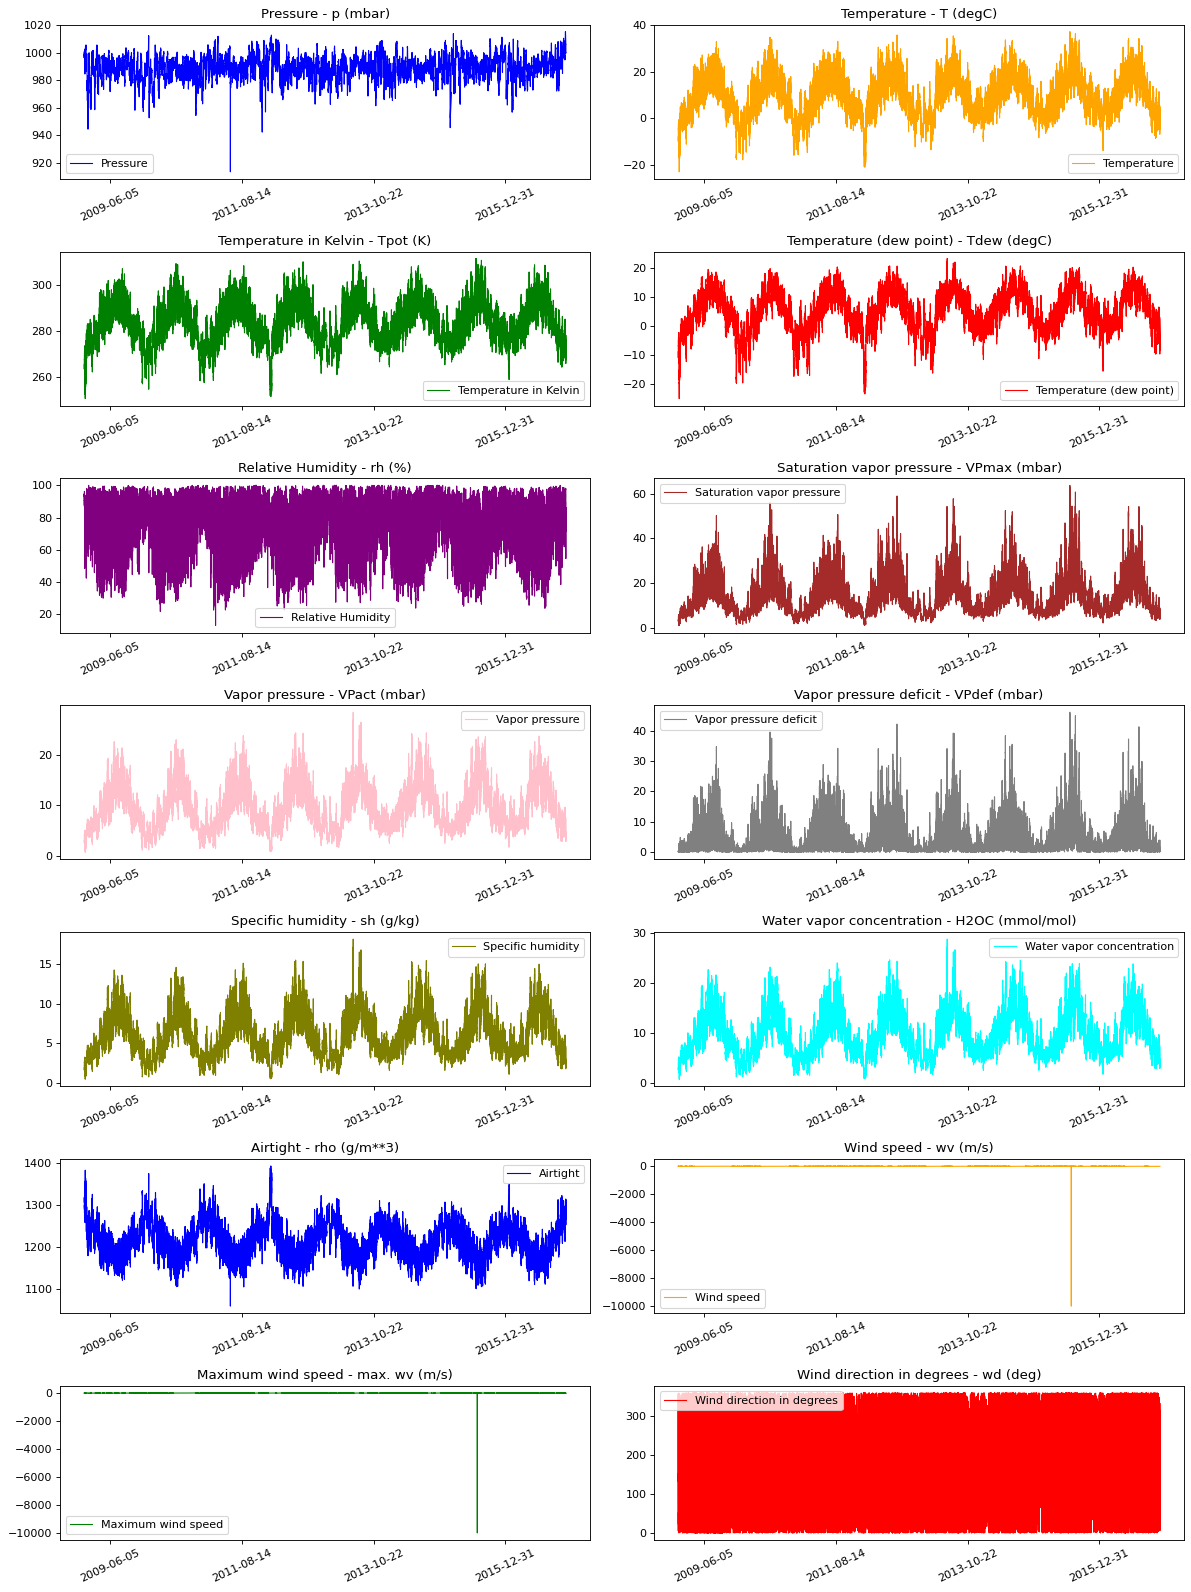

In [12]:
titles = ["Pressure", "Temperature", "Temperature in Kelvin", "Temperature (dew point)", "Relative Humidity", "Saturation vapor pressure",
          "Vapor pressure", "Vapor pressure deficit", "Specific humidity", "Water vapor concentration", "Airtight", "Wind speed",
          "Maximum wind speed", "Wind direction in degrees"]

feature_keys = [ "p (mbar)", "T (degC)", "Tpot (K)", "Tdew (degC)", "rh (%)", "VPmax (mbar)", "VPact (mbar)", "VPdef (mbar)", "sh (g/kg)",
                "H2OC (mmol/mol)", "rho (g/m**3)", "wv (m/s)", "max. wv (m/s)", "wd (deg)"]

colors = [ "blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan"]

def show_raw_visualization(data):
    data = data.copy()
    time_data = data["Date Time"].values
    fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k")

    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        ax = axes[i // 2, i % 2]
        ax.plot(time_data, data[key].values, color=c, linewidth=1)
        ax.set_title(f"{titles[i]} - {key}")
        ax.legend([titles[i]])
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        plt.setp(ax.get_xticklabels(), rotation=25)

    plt.tight_layout()
    plt.show()

show_raw_visualization(df)

Significant anomalies are found in the variables `wv (m/s)` and `max. wv (m/s)`. Specifically, the data show negative values, which, given the wind speed, are physically inconsistent and clearly attributable to measurement errors or instrumentation failures.

Before proceeding, let's address these outliers.

### 2.1 Wind Data Fix

Let's see what the smallest values ​​are

In [13]:
# Sort by first column and show both
print("Top 20 minimum values ​​based on 'wv (m/s)':")
print(df.sort_values(by='max. wv (m/s)', ascending=True)[['wv (m/s)', 'max. wv (m/s)']].head(21))
print("Number of negative values ​​in the two columns:")
print(f'wv (m/s): {df[df['wv (m/s)'] < 0].shape[0]}', f'max. wv (m/s): {df[df['max. wv (m/s)'] < 0].shape[0]}')

Top 20 minimum values ​​based on 'wv (m/s)':
        wv (m/s)  max. wv (m/s)
343352  -9999.00        -9999.0
343360  -9999.00        -9999.0
343361  -9999.00        -9999.0
343362  -9999.00        -9999.0
343366  -9999.00        -9999.0
343363  -9999.00        -9999.0
343365  -9999.00        -9999.0
343364  -9999.00        -9999.0
343367  -9999.00        -9999.0
343368     28.49        -9999.0
343349      6.16        -9999.0
343350  -9999.00        -9999.0
343351  -9999.00        -9999.0
343356  -9999.00        -9999.0
343357  -9999.00        -9999.0
343358  -9999.00        -9999.0
343359  -9999.00        -9999.0
343353  -9999.00        -9999.0
343354  -9999.00        -9999.0
343355  -9999.00        -9999.0
33857       0.00            0.0
Number of negative values ​​in the two columns:
wv (m/s): 18 max. wv (m/s): 20


The problematic values ​​reside in the same time window and are clearly error codes typical of meteorological datasets. Leaving them as they are would destroy the model. So I decided to replace these values ​​with `NaN` values.



In [14]:
df['wv (m/s)'] = df['wv (m/s)'].replace(-9999.0, np.nan)
df['max. wv (m/s)'] = df['max. wv (m/s)'].replace(-9999.0, np.nan)

I fill the `NaN`s with a linear interpolation

In [15]:
df['wv (m/s)'] = df['wv (m/s)'].interpolate(method='linear')
df['max. wv (m/s)'] = df['max. wv (m/s)'].interpolate(method='linear')

Let's look at the values ​​of the time window under examination

In [16]:
print(df[["wv (m/s)", "max. wv (m/s)"]].iloc[343349:343367])

         wv (m/s)  max. wv (m/s)
343349   6.160000       5.171429
343350   7.335263       5.122857
343351   8.510526       5.074286
343352   9.685789       5.025714
343353  10.861053       4.977143
343354  12.036316       4.928571
343355  13.211579       4.880000
343356  14.386842       4.831429
343357  15.562105       4.782857
343358  16.737368       4.734286
343359  17.912632       4.685714
343360  19.087895       4.637143
343361  20.263158       4.588571
343362  21.438421       4.540000
343363  22.613684       4.491429
343364  23.788947       4.442857
343365  24.964211       4.394286
343366  26.139474       4.345714




---



Let's resume the statistical analysis of the variables, focusing on their distributions. Below are the density plots, supplemented by the calculation of skewness and kurtosis, to assess how much the data deviates from a normal distribution.

In [17]:
from scipy.stats import skew, kurtosis
import scipy.stats as stats

def analyze_feature_stats(df, features):
    n_features = len(features)
    fig, axes = plt.subplots(n_features, 2, figsize=(15, 4 * n_features), squeeze=False)

    for i, col in enumerate(features):
        s = skew(df[col])
        k = kurtosis(df[col])

        sns.histplot(df[col], kde=True, ax=axes[i, 0], color="skyblue")
        axes[i, 0].set_title(f"Distribution {col}\nSkew: {s:.2f} | Kurtosis: {k:.2f}")
        axes[i, 0].axvline(df[col].mean(), color='red', linestyle='--', label='Mean')
        axes[i, 0].axvline(df[col].median(), color='green', linestyle='-', label='Median')
        axes[i, 0].legend(loc='upper right')

        stats.probplot(df[col], dist="norm", plot=axes[i, 1])
        axes[i, 1].set_title(f"Q-Q Plot di {col}")

    plt.tight_layout()
    plt.show()

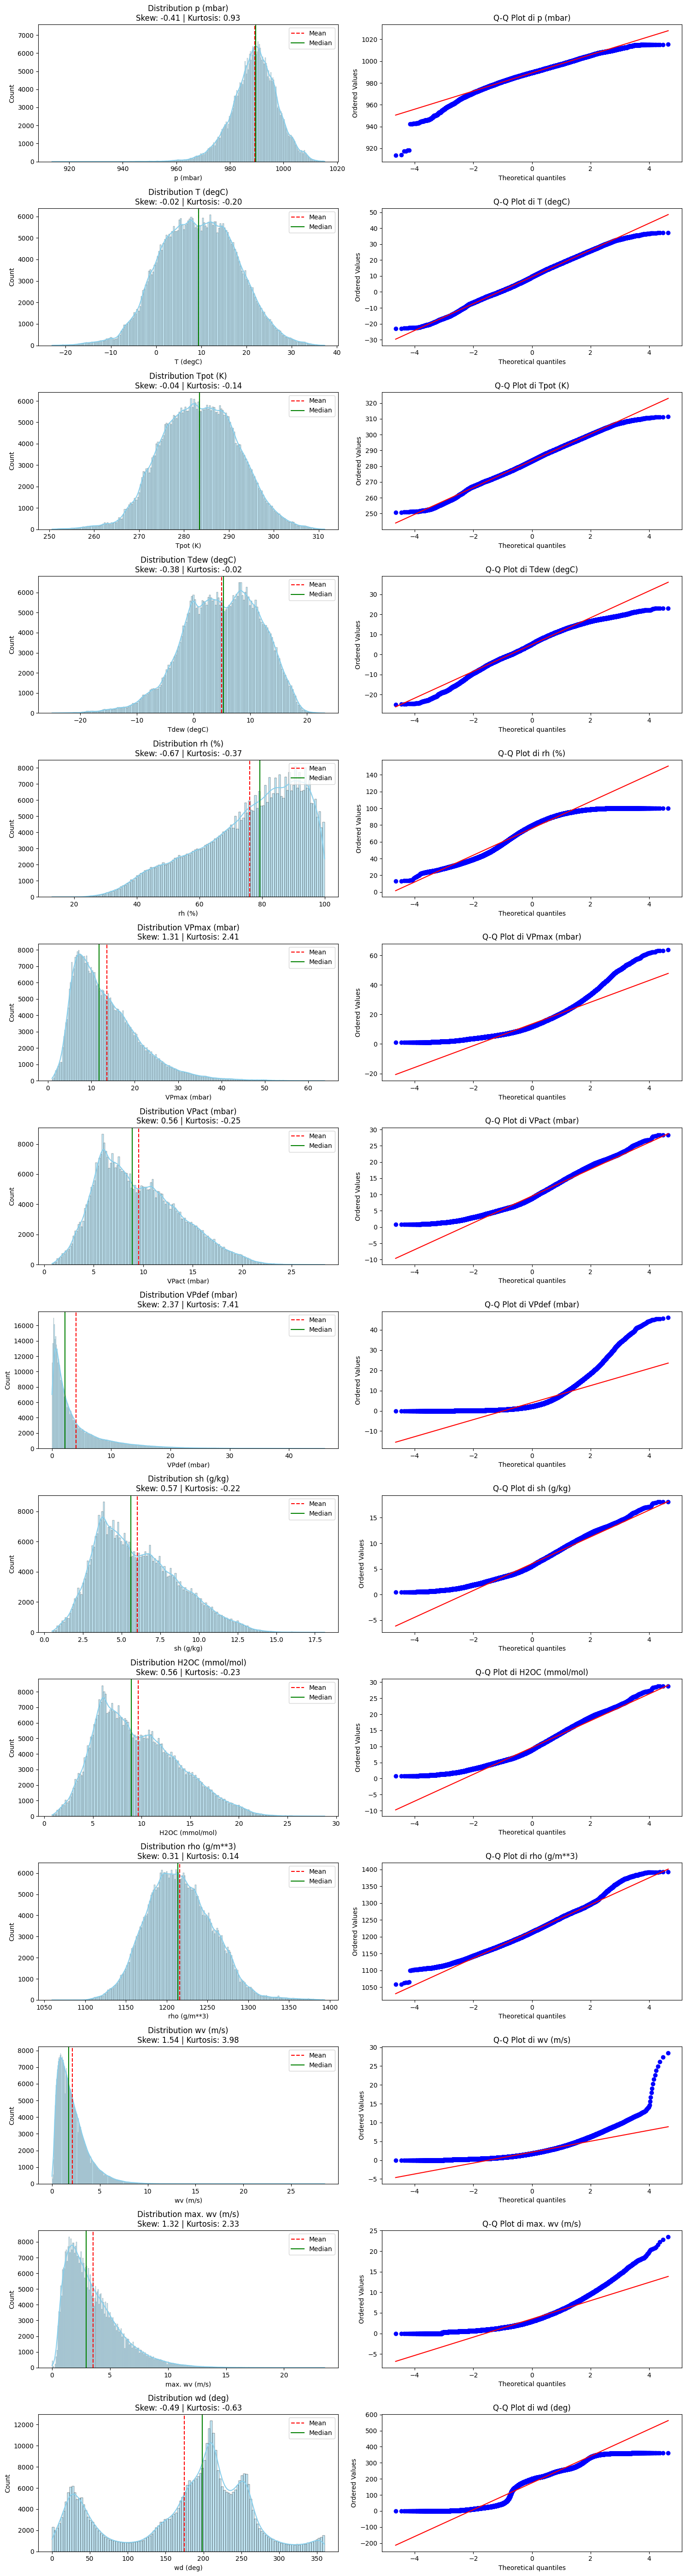

In [18]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
analyze_feature_stats(df, numeric_cols)

From the analysis of the histograms, Q-Q plots, and statistical moments (Skewness and Kurtosis), four categories of variables emerge:

1. "Quasi-Gaussian" variables (Ready-to-use):
    * **Feature**: `p (mbar)`, `T (degC)`, `rho (g/m**3)`.
    * **Observation**: They exhibit a skewness close to 0 and a low Kurtosis. The Q-Q plots show excellent alignment with the normal distribution in the central portion (where 99% of the data reside). The tails diverge slightly, representing extreme weather events (physical, not errors).
    * **Decision**: They can be passed directly to the StandardScaler.

2. Asymmetric / "Long-Tailed" Variables (Skewed):
    * **Feature**: `wv (m/s)`, `VPdef (mbar)`, `VPmax (mbar)`, `VPact (mbar)`.
    * **Observation**: They exhibit strong positive skewness (Skewness > 1 or very high, such as 2.37 for VPdef) and heavy tails (high Kurtosis). The Q-Q plot shows a nonlinear shape, indicating that direct standardization would flatten the variance of common values, making the model insensitive.
    * **Decision**: They require a logarithmic transformation (`np.log1p`) to stabilize the variance and make the distribution more symmetric before scaling.

3. Redundant Variables (Multicollinearity):
    * **Feature**: `H2OC (mmol/mol)`, `sh (g/kg)`, `Tpot (K)`, `max. wv (m/s)`.
    * **Observation**: Correlation analysis and distribution overlap confirm that these variables carry the same physical information as `VPact`, `T`, and `wv`.
    * **Decision**: They will be removed (Drop) to reduce computational complexity and avoid instability in the model weights.

4. Special Variables:
    * `wd (deg)` (**Wind Direction**): Since it is a circular data point (0° = 360°), the classical statistical distribution is not informative. It must be transformed into Cartesian vectors (`wx, wy`).
    * `rh (%)` (**Humidity**): It has negative skewness (left tail). Although not ideal, the logarithm is not applicable (opposite asymmetry). It will be maintained and handled by the scaler, since the 100% "wall" is a significant physical limit.

## 3 Feature Engineering

Let's start by dropping redundant variables from the dataset:

In [19]:
cols_to_drop = ['H2OC (mmol/mol)', 'sh (g/kg)', 'max. wv (m/s)', 'Tpot (K)']
df = df.drop([c for c in cols_to_drop if c in df.columns], axis=1)

Let's transform the wind into Cartesian vectors

In [20]:
df['wx (m/s)'] = df['wv (m/s)']*np.cos(df['wd (deg)']*np.pi/180)
df['wy (m/s)'] = df['wv (m/s)']*np.sin(df['wd (deg)']*np.pi/180)
df = df.drop(["wv (m/s)", "wd (deg)"], axis=1)

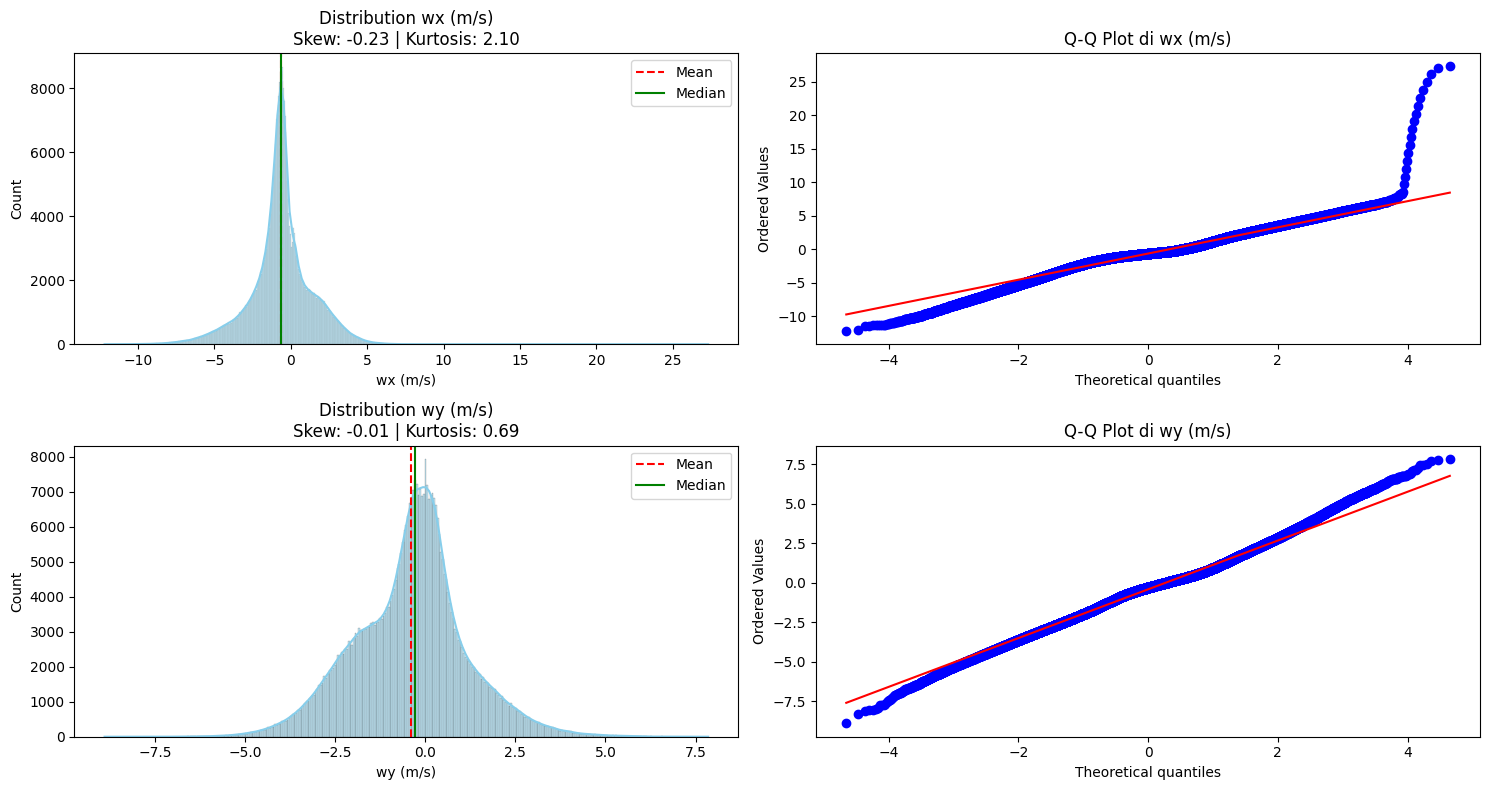

In [21]:
analyze_feature_stats(df, ['wx (m/s)', 'wy (m/s)'])

Vectorization has transformed the wind (`wv (m/s)`, `wd (deg)`) from a “problematic” feature to one of the cleanest features in the dataset, so it will not need any transformations.

We then apply the `np.log1p` transformation to all the asymmetric variables

In [22]:
log_features = ['VPdef (mbar)', 'VPmax (mbar)', 'VPact (mbar)']

for col in log_features:
    if col in df.columns:
        df[col] = np.log1p(df[col])

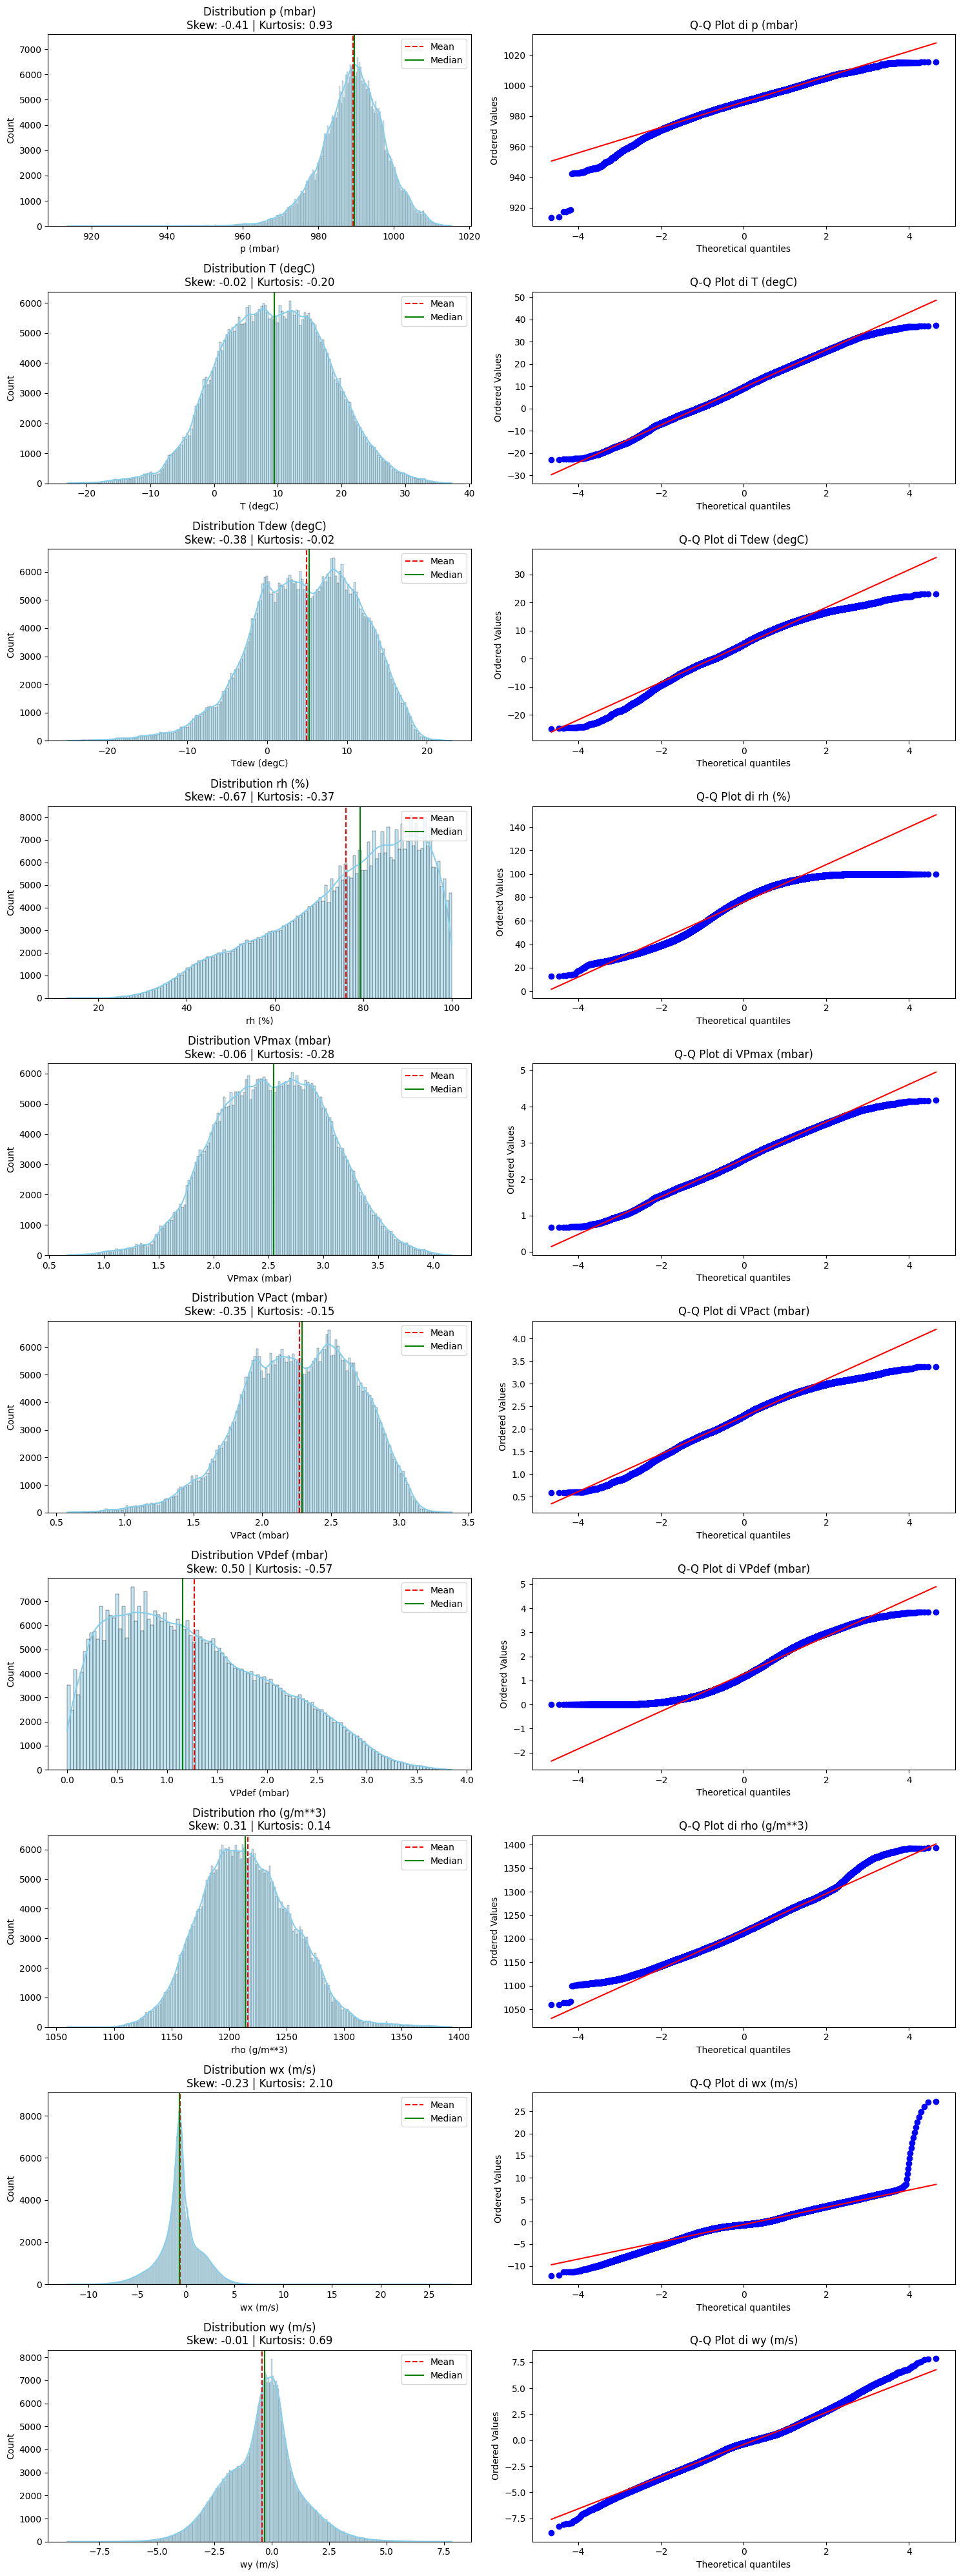

In [23]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
analyze_feature_stats(df, numeric_cols)

Post-transformation analysis confirms the effectiveness of the operation:

* **Skewness** and **Kurtosis**: The values ​​have dropped dramatically, approaching zero (indicating a symmetric distribution).

* **QQ-Plot**: The Quantile-Quantile plots now show a much closer alignment to the theoretical normal distribution line (red line), indicating that the data have been successfully "Gaussianized."

### 3.1 Cyclical Time Encoding

Weather data is inherently cyclical. However, a deep learning model has no innate understanding of time. If we provided the time as a simple sequential number (e.g., $0, 1, ..., 23$), the model would make a serious interpretation error:
* Mathematically, the distance between $23:00$ and $00:00$ would be 23.
* Physically, the distance is 1 hour (they are contiguous).

This numerical "jump" prevents the model from understanding that the end of a cycle connects to the beginning. To solve this problem and preserve the circular topology of time, we transform the DateTime column into coordinates on a unit circle using the Sine and Cosine functions.
We use two components ($sin, cos$) for each time frequency because a single periodic function would present ambiguities (e.g., the same sine value appears twice in a cycle). The pair $(x, y)$ instead uniquely identifies each instant.

We apply this transformation to two fundamental climate frequencies:
1. **Daily Cycle** (Day sin, Day cos):
    * **Period**: $24$ hours ($86,400$ seconds).
    * **Objective**: Capture circadian patterns (e.g., day/night temperature range, solar breeze).
2. **Annual Cycle** (Year sin, Year cos):
    * **Period**: $1$ year ($\approx 365.2425$ days).
    * **Objective**: Capture seasonality (e.g., average winter vs. summer temperatures).

In this way, "time" is no longer an infinitely growing line, but a set of wave signals that drive the model through the seasons and hours of the day.

In [24]:
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24 * 60 * 60
year = (365.2425) * day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

if 'Date Time' in df.columns:
    df = df.drop('Date Time', axis=1)

In [25]:
df.columns

Index(['p (mbar)', 'T (degC)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)',
       'VPact (mbar)', 'VPdef (mbar)', 'rho (g/m**3)', 'wx (m/s)', 'wy (m/s)',
       'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

### 3.2 Heatmap

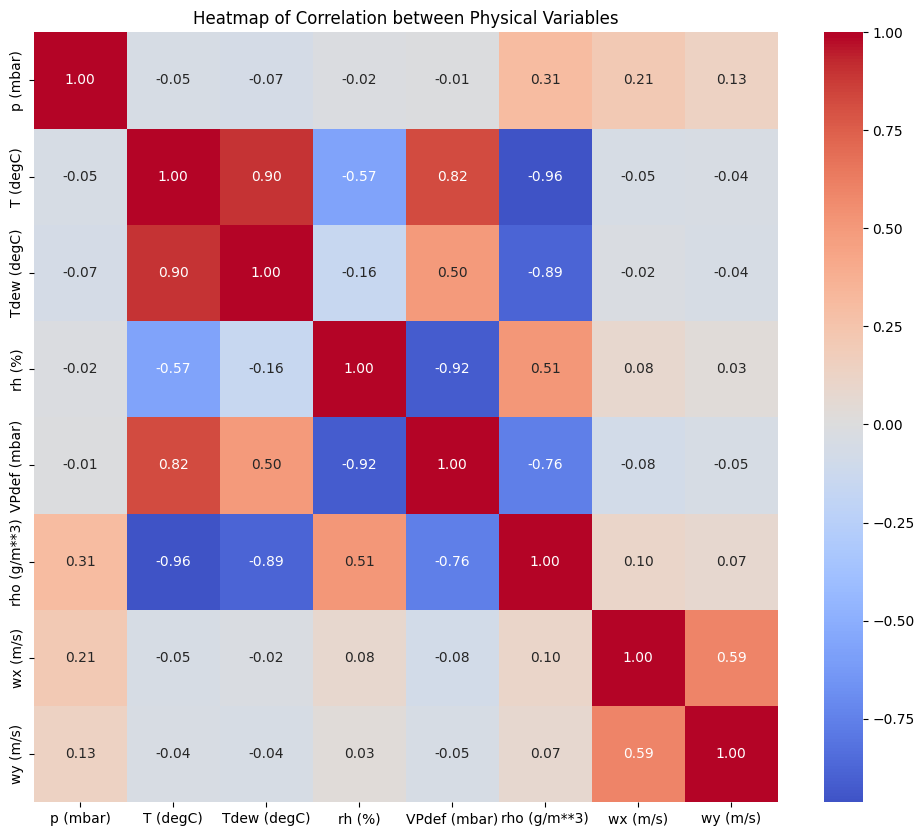

In [26]:
value_columns = ['p (mbar)', 'T (degC)', 'Tdew (degC)', 'rh (%)', 'VPdef (mbar)', 'rho (g/m**3)', 'wx (m/s)', 'wy (m/s)']
corr_matrix = df[value_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Heatmap of Correlation between Physical Variables")
plt.show()

Looking at the heatmap, we notice an interesting detail: some variables such as Pressure (`p (mbar)`) and Wind Vectors (`wx, wy`) show a very low Pearson correlation (close to 0) with the target temperature (`T (degC)`).

In a classical statistical approach, it would be natural to remove these features. However, our empirical tests show that their removal **drastically worsens the model's performance**. Why does this happen? The answer lies in the physics of the system and the nature of neural networks:
1. **Non-Linearity and Time Delay**: Pearson correlation only measures instantaneous linear relationships. However, the relationship between Pressure/Wind and Temperature is **complex, non-linear, and often lagged in time**:
    * **Pressure (`p`)**: Atmospheric pressure is a predictive, non-contemporaneous indicator. A drop in pressure today often predicts the arrival of a weather front (and therefore a change in temperature) tomorrow. The model learns this temporal cause-and-effect relationship that the simple heatmap ignores.
    * **Wind (`w_x, w_y`)**: Wind is the driver of Thermal Advection. It's not the wind itself that's warm or cold, but the wind transports air masses.
2. **Synergy between Variables**: Deep learning models excel at finding interactions between variables. Pressure alone might mean little, but the combination of "falling pressure + north wind + high humidity" is a powerful signal for predicting future temperatures. Removing one of these components destroys the physical context the network needs to make correct inferences.

**Conclusion**: We keep all physical variables (`p, wx, wy`) in the final dataset, since their information content is latent and temporal, essential for Loss minimization.

## 4 Preprocessing

### 4.1 Downsampling

The original dataset is recorded very frequently (every 10 minutes). While this granularity provides a wealth of detail, it presents two main disadvantages for training a medium-term forecasting model: noise and redundancy.

A good choice is hourly sampling (Downsampling), which guarantees a cleaner, more stable, and computationally lighter signal, improving the model's ability to generalize to macroscopic trends.

In [27]:
df_hourly = df[5::6].copy()
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 5 to 420767
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   p (mbar)      70128 non-null  float64
 1   T (degC)      70128 non-null  float64
 2   Tdew (degC)   70128 non-null  float64
 3   rh (%)        70128 non-null  float64
 4   VPmax (mbar)  70128 non-null  float64
 5   VPact (mbar)  70128 non-null  float64
 6   VPdef (mbar)  70128 non-null  float64
 7   rho (g/m**3)  70128 non-null  float64
 8   wx (m/s)      70128 non-null  float64
 9   wy (m/s)      70128 non-null  float64
 10  Day sin       70128 non-null  float64
 11  Day cos       70128 non-null  float64
 12  Year sin      70128 non-null  float64
 13  Year cos      70128 non-null  float64
dtypes: float64(14)
memory usage: 7.5 MB


### 4.2 Splitting & Scaling

After deciding on the dataset's split ratio (70/20/10), we calculate the exact numerical indices that will delimit the three datasets. This operation is essential to ensure there is no overlap between the dataset segments.

The calculation is based on the total number of rows in the hourly dataset:

- `train_split`: Identifies the end of the training window.

- `val_split`: Defines the size of the validation window.

- `test_split`: Calculated by difference, it contains the final (and most recent) portion of the dataset for final evaluation.

This static split based on the indices will allow us, in the next step, to isolate the original DataFrame portions before proceeding with normalization.

In [28]:
train_split = int(0.7 * int(df_hourly.shape[0]))
val_split = int(0.2 * int(df_hourly.shape[0]))
test_split = int(df_hourly.shape[0]) - train_split - val_split

print(f"Training samples:   {train_split}")
print(f"Validation samples: {val_split}")
print(f"Test samples:       {test_split}")

Training samples:   49089
Validation samples: 14025
Test samples:       7014


Let's isolate the three datasets. It's crucial to maintain chronological order to prevent the model from using information from the future to predict the past.

In [29]:
df_train = df_hourly[:train_split]
df_val = df_hourly[train_split:train_split+val_split]
df_test = df_hourly[train_split+val_split:]

Before proceeding with standardization, we separate the dataset into two groups:
* **Cyclic Variables** (time): Already confined to the interval $[-1, 1]$, they do not require scaling.
* **Physical Variables** (phys): Variables with different units of measurement and ranges, which require standardization to optimize model convergence.

We apply the StandardScaler, calculating mean and variance exclusively on the Training set. This parameter will then be used to transform the Validation and Test sets, ensuring no data leakage (i.e., preventing future statistical information from influencing training).

In [30]:
# Time variables
df_train_time = df_train[['Day sin', 'Day cos', 'Year sin', 'Year cos']]
df_val_time = df_val[['Day sin', 'Day cos', 'Year sin', 'Year cos']]
df_test_time = df_test[['Day sin', 'Day cos', 'Year sin', 'Year cos']]
# Physical variables
df_train_phys = df_train.drop(['Day sin', 'Day cos', 'Year sin', 'Year cos'], axis=1)
df_val_phys = df_val.drop(['Day sin', 'Day cos', 'Year sin', 'Year cos'], axis=1)
df_test_phys = df_test.drop(['Day sin', 'Day cos', 'Year sin', 'Year cos'], axis=1)

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Fit and transformation for training dataset
df_train_phys_scaled = pd.DataFrame(scaler.fit_transform(df_train_phys),
                                    columns=df_train_phys.columns,
                                    index=df_train_phys.index)
# Only transformation for validation dataset
df_val_phys_scaled = pd.DataFrame(scaler.transform(df_val_phys),
                                  columns=df_val_phys.columns,
                                  index=df_val_phys.index)
# Only transformation for test dataset
df_test_phys_scaled = pd.DataFrame(scaler.transform(df_test_phys),
                                   columns=df_test_phys.columns,
                                   index=df_test_phys.index)

Finally, we combine the temporal (cyclic) features with the physical (standardized) features. This produces the three final datasets—Train, Validation, and Test—ready to be transformed into time windows (windowing).

In [32]:
# Concatenetion
df_train = pd.concat([df_train_time, df_train_phys_scaled], axis=1)
df_val = pd.concat([df_val_time, df_val_phys_scaled], axis=1)
df_test = pd.concat([df_test_time, df_test_phys_scaled], axis=1)

In [33]:
df_train.describe().transpose()[['mean', 'std', 'min', 'max']]

mean       std       min       max
Day sin       1.392763e-04  0.707131 -1.000000  1.000000
Day cos       3.731898e-05  0.707097 -1.000000  1.000000
Year sin      5.124354e-02  0.700516 -1.000000  1.000000
Year cos     -1.720915e-02  0.711601 -1.000000  1.000000
p (mbar)     -1.614205e-15  1.000010 -8.459381  2.903317
T (degC)      8.800546e-17  1.000010 -3.684046  3.048514
Tdew (degC)  -4.631866e-18  1.000010 -4.214328  2.626629
rh (%)       -1.130175e-15  1.000010 -3.803943  1.455137
VPmax (mbar) -3.612856e-16  1.000010 -3.478067  2.911013
VPact (mbar) -8.985820e-16  1.000010 -3.834821  2.586887
VPdef (mbar) -1.320082e-16  1.000010 -1.585428  3.126018
rho (g/m**3)  2.088972e-15  1.000010 -3.683463  4.288402
wx (m/s)     -1.389560e-17  1.000010 -5.206695  4.368185
wy (m/s)      3.126510e-17  1.000010 -4.385036  5.023714

Statistical testing confirms the success of **Z-score normalization**, with the physical variables centered on a zero mean and rescaled to unit variance to ensure balanced weighting during training.

## 5 Modeling Strategy

In this central phase of the project, we are building and training predictive models for multi-step forecasting (24 hours ahead).

The methodological approach is structured into three logical steps:

1. **Windowing**: Transforming the dataset into temporal sequences (sliding windows) of input and target data.

2. **Callback**: Defining a common callback configuration to ensure fair and rigorous comparisons between different architectures.

3. **Incremental Experimentation**: Testing three architectures of increasing complexity to evaluate the trade-off between computational costs and accuracy:

    * **DLinear**: A robust and interpretable linear baseline.

    * **BiLSTM**: A deep recurrent approach for capturing sequential dependencies.

    * **TSMixer**: A modern "All-MLP" architecture that represents the state of the art in efficiency.

### 5.1 Windowing

The dataset is currently organized as a two-dimensional matrix. To train the models, we need to transform it into a sliding "window" structure. Each example will consist of:
* **Input** (Look-back): e.g., a 120-hour (5-day) sequence of past data.
* **Target** (Label): e.g., a 24-hour (1-day) sequence of future data that the model must learn to predict.

In [34]:
seq_len = 24 * 5  # Hours to see back
pred_len = 24     # Prediction time
batch_size = 32

Specifically, we implement a function that converts DataFrames into `tf.data.Dataset` objects.

This implementation uses a `lambda` function to divide each window into **Input** (the first `seq_len` steps) and **Target** (the subsequent `pred_len` steps). Finally, the use of `prefetch` allows batches to be loaded in the background, reducing training downtime.

In [35]:
from tensorflow.keras.utils import timeseries_dataset_from_array

def create_windowed_dataset(data, shuffle, seq_len, pred_len, batch_size=32, seed=RANDOM_SEED):

    dataset = timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=seq_len + pred_len,
        sequence_stride=1,
        shuffle=shuffle,
        seed=seed,
        batch_size=batch_size,
    )
    dataset = dataset.map(lambda window: (window[:, :seq_len, :], window[:, seq_len:, :]))

    return dataset.prefetch(tf.data.AUTOTUNE)

We use the previously defined function to create the three datasets. At this stage, we apply different configurations to ensure the integrity of the evaluation:
- **train_ds**: Shuffle is set to `True`. This is essential during training to "break" the temporal correlation between consecutive batches and push the model to learn general patterns rather than memorizing the specific sequence.
- **val_ds** and **test_ds**: Shuffle is set to `False`. Validation and testing must occur in a linear chronological order to accurately reflect how the model would perform in a real-world deployment, where data arrives sequentially.

All datasets are now configured as 3D generators with shape `(Batch_Size, Time_Steps, Features)`.

In [36]:
train_ds = create_windowed_dataset(df_train.values, shuffle=True,  seq_len=seq_len, pred_len=pred_len, batch_size=batch_size)
val_ds   = create_windowed_dataset(df_val.values,   shuffle=False, seq_len=seq_len, pred_len=pred_len, batch_size=batch_size)
test_ds  = create_windowed_dataset(df_test.values,  shuffle=False, seq_len=seq_len, pred_len=pred_len, batch_size=batch_size)

for inputs, targets in train_ds.take(1):
    print(f'Input shape (batch, seq_len, features): {inputs.shape}')
    print(f'Target shape (batch, pred_len, features): {targets.shape}')

Input shape (batch, seq_len, features): (32, 120, 14)
Target shape (batch, pred_len, features): (32, 24, 14)


### 5.2 CallBack

Before delving into the individual architectures, let's **define a common training strategy**. To ensure a fair comparison between models, we will use the same **Callbacks** configuration for all of them. These tools monitor the training process in real time and intervene to optimize performance and prevent overfitting.

The `create_callbacks` function implements three key mechanisms:

1. **ModelCheckpoint**: Automatically saves the model weights only when an improvement in the Validation Loss (`val_loss`) is observed. This ensures we always retain the "best" version of the model, not necessarily the latest one (which could be overfitted).

2. **ReduceLROnPlateau**: This is an automatic fine-tuning mechanism. If the validation loss stops decreasing for a certain number of epochs (`patience=3`), the Learning Rate is halved (`factor=0.5`). This allows the model to take smaller steps toward the global minimum of the error function.

3. **EarlyStopping**: Stops training if there are no significant improvements (`min_delta=1e-4`) for a long period (`patience=10`). This saves computational resources and is the primary defense against overfitting.

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def create_callbacks(model_name):
    checkpoint_path = f"models/best_{model_name}.keras"

    callbacks = [
        ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=0
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1,
            min_delta=1e-4
        )
    ]

    return callbacks

### 5.3 Model Architecture: DLinear (Time-Series Decomposition)

The **DLinear** (Decomposition Linear) model represents a paradigm shift compared to complex Transformer-based models for time series. Despite its simplicity based on linear layers, it often surpasses them in accuracy and speed.

The intuition behind DLinear is that a time series is composed of **two distinct signals** that evolve according to different logics:
- **Trend-Cycle**: The long-term component that represents the general direction of the data (e.g., the gradual increase in temperature throughout the day).
- **Seasonal**: The short-term or periodic fluctuations that repeat around the trend (e.g., local micro-variations).

DLinear "assists" the neural network by pre-processing the signal:
- **Explicit Decomposition**: Instead of asking the model to learn everything at once, we separate the trend from the seasonality using a Moving Average.
- **Channel Independence**: The model works on the time series of each feature independently (through channel permutation), preventing noise from one variable from "polluting" the others when extracting temporal patterns.
- **Robustness**: Being fundamentally linear, it is less prone to overfitting than models with millions of parameters, while maintaining the ability to extract complex trends thanks to signal separation.

To translate this philosophy into computational architecture, we implement a **Custom Layer** called `SeriesDecomposition`. This layer acts as a frequency separator:
* **The Trend** ($X_t$): This is extracted by applying `1D AveragePooling`. Mathematically, this is equivalent to a Moving Average that "smooths" the time series, eliminating high-frequency noise to isolate the long-term direction.
* **Seasonality** ($X_s$): This is obtained by subtraction ($X - X_t$). This residual contains all the periodic variations and details that oscillate around the trend.

**Technical Note**: About `Kernel Size = 25`: We use a filter of size 25 to cover the span of an hourly day. Choosing an odd number (25 instead of 24) is crucial with the `padding='same'`: it allows the filter to be perfectly centered, looking exactly 12 hours in the past and 12 hours in the future with respect to the current instant, avoiding time skews in the signal.

In [38]:
class SeriesDecomposition(layers.Layer):
    """
    Subtracts the trend using a moving average.
    Input: (Batch, Length, Channels)
    Output: (Seasonal, Trend)
    """
    def __init__(self, kernel_size=25):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = layers.AveragePooling1D(pool_size=kernel_size, strides=1, padding='same')

    def call(self, x):
        trend = self.avg(x)
        seasonal = x - trend
        return seasonal, trend

Once the signals are separated, the `build_enhanced_dlinear` function defines the prediction logic. The architecture follows three key steps:
1. **Channel Independence (Permute)**: Instead of mixing all the variables, the model rotates the data to treat each channel (physical variable) as an independent time series. This approach dramatically reduces complexity and prevents cross-variable noise.
2. **Non-Linear Refinement (optional MLP)**: Compared to the standard DLinear (which is purely linear), this "Enhanced" version allows the insertion of intermediate dense layers with **ReLU** and **Dropout** activations. This allows the model to learn more complex relationships within the trend and seasonality components if necessary.
3. **Projection and Reintegration**: Two final linear layers project the components from the past window (`seq_len`) to the future horizon (`pred_len`). Finally, the branches are summed to reconstruct the complete forecast.

In [39]:
def build_enhanced_dlinear(seq_len, pred_len, num_channels, hidden_units=None, dropout_rate=0.0):
    inputs = keras.Input(shape=(seq_len, num_channels), name="Input_Layer")

    # Decomposition
    seasonal, trend = SeriesDecomposition()(inputs)

    # (batch, seq_len, num_channels) -> (batch, num_channels, seq_len)
    seasonal = layers.Permute((2, 1), name="Permute_Seasonal_In")(seasonal)
    trend = layers.Permute((2, 1), name="Permute_Trend_In")(trend)

    # Intermediate Layers (MLP)
    if hidden_units:
        for i, units in enumerate(hidden_units):
            # Seasonal
            seasonal = layers.Dense(units, activation = 'relu', name=f"Dense_Seasonal_{i+1}")(seasonal)
            seasonal = layers.Dropout(dropout_rate, name=f"Dropout_Seasonal_{i+1}")(seasonal)

            # Trend
            trend = layers.Dense(units, activation = 'relu', name=f"Dense_Trend_{i+1}")(trend)
            trend = layers.Dropout(dropout_rate, name=f"Dropout_Trend_{i+1}")(trend)

    # Final Projection
    seasonal_out = layers.Dense(pred_len, name="Linear_Projection_Seasonal")(seasonal)
    trend_out = layers.Dense(pred_len, name="Linear_Projection_Trend")(trend)

    # Recomposition
    x = layers.Add(name="Sum_Components")([seasonal_out, trend_out])

    # (batch, num_channels, pred_len) -> (Batch, pred_len, num_channels)
    outputs = layers.Permute((2, 1), name="Output_Reshape")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="Enhanced_DLinear")
    return model

In this phase, we define the final structure of our **Enhanced DLinear** and configure the learning process:
1. **Loss Function**: We choose the **Mean Squared Error (MSE)**. This function is particularly effective for weather because it penalizes large errors quadratically, encouraging the model to avoid making predictions that are excessively distant from the actual values.
2. **Optimizer**: We use Adam with a learning rate of 0.001, the standard for ensuring rapid and stable convergence to the minimum of the error function.

In [40]:
tf.keras.backend.clear_session()

model_dl = build_enhanced_dlinear(seq_len, pred_len, len(df_hourly.columns),[64])
model_dl.summary()

model_dl.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

Model: "Enhanced_DLinear"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 120, 14)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ series_decompositi… │ [(None, 120, 14), │          0 │ Input_Layer[0][0] │
│ (SeriesDecompositi… │ (None, 120, 14)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Permute_Seasonal_In │ (None, 14, 120)   │          0 │ series_decomposi… │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Permute_Trend_In    │ (None, 14, 120)   │          0 │ series_decomposi… │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Seasonal_1    │ (None, 14, 64)    │      7,744 │ Permute_Seasonal… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Trend_1       │ (None, 14, 64)    │      7,744 │ Permute_Trend_In… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_Seasonal_1  │ (None, 14, 64)    │          0 │ Dense_Seasonal_1… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_Trend_1     │ (None, 14, 64)    │          0 │ Dense_Trend_1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Linear_Projection_… │ (None, 14, 24)    │      1,560 │ Dropout_Seasonal… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Linear_Projection_… │ (None, 14, 24)    │      1,560 │ Dropout_Trend_1[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Sum_Components      │ (None, 14, 24)    │          0 │ Linear_Projectio… │
│ (Add)               │                   │            │ Linear_Projectio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Reshape      │ (None, 24, 14)    │          0 │ Sum_Components[0… │
│ (Permute)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,608 (72.69 KB)

 Trainable params: 18,608 (72.69 KB)

 Non-trainable params: 0 (0.00 B)

We start training using the pre-processed training set

In [41]:
history_dl = model_dl.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=create_callbacks('model_dl')
)

Epoch 1/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2929 - mae: 0.3422 - val_loss: 0.2145 - val_mae: 0.2874 - learning_rate: 0.0010
Epoch 2/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2124 - mae: 0.2838 - val_loss: 0.2115 - val_mae: 0.2813 - learning_rate: 0.0010
Epoch 3/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2094 - mae: 0.2807 - val_loss: 0.2091 - val_mae: 0.2800 - learning_rate: 0.0010
Epoch 4/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2075 - mae: 0.2786 - val_loss: 0.2099 - val_mae: 0.2794 - learning_rate: 0.0010
Epoch 5/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2061 - mae: 0.2769 - val_loss: 0.2087 - val_mae: 0.2764 - learning_rate: 0.0010
Epoch 6/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2049 - mae: 0.2755 - val_loss: 0.2073 - val_mae: 0.2757 - learning_rate: 0.0010
Epoch 7/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2038 - mae: 0.2742 - val_loss: 0.2067 - val_mae: 0.2762 - learnin

Training shows immediate convergence. The parallel and close trend of the loss curves (gap of only ~0.008) certifies excellent generalization ability and the complete absence of overfitting. However, frequent `ReduceLROnPlateau` interventions indicate early saturation: the model quickly extracted all possible linear dependencies, hitting a performance "wall" (`val_loss: 0.2029`) beyond which it cannot descend, thus establishing a solid baseline for subsequent models.

### 5.4 Model Architecture: BiLSTM

After establishing a solid baseline with the linear model (DLinear), we now introduce an architecture based on **Recurrent Neural Networks** (RNNs), historically the standard for processing temporal sequences.

Specifically, we use a **BiLSTM** (Bidirectional Long Short-Term Memory).

While DLinear assumes that relationships are primarily linear and direct, LSTMs are designed to capture long-term nonlinear dependencies. The Bidirectional variant processes the input sequence (the past 120 hours) in two directions:
1. **Forward**: From the most distant past ($t_{-120}$) to the present ($t_{0}$).
2. **Backward**: From the present ($t_{0}$) back to ($t_{-120}$).

This allows the network to have a more complete view of local patterns within the time window, capturing correlations that a one-way read might miss.

The model implemented using the `build_bilstm_model` function is of the **Compressed Encoder-Decoder** type:

1. **Encoder (BiLSTM)**: The input sequence `(seq_len, num_channels)` is "read" and compressed into a single latent vector. By setting `return_sequences=False`, we force the LSTM to summarize all the information into a single context vector.

2. **Decoder (Dense)**: This vector is projected directly into the output space `(pred_len x num_channels)` via a dense layer, which acts as a universal decoder.

3. **Reshape**: Finally, we resize the output to match the required `(pred_len, num_channels)` format.

In [42]:
def build_bilstm_model(seq_len, pred_len, num_channels, units=32, dropout=0.2):

    inputs = keras.Input(shape=(seq_len, num_channels), name="Input_Layer")
    # ENCODER
    x = layers.Bidirectional(layers.LSTM(units, return_sequences=False), name="BiLSTM_Processor")(inputs)
    x = layers.Dropout(dropout, name="Dropout_Regularizer")(x)
    # DECODER
    x = layers.Dense(pred_len * num_channels, name="Dense_Output_Projection")(x)
    # RESHAPE
    outputs = layers.Reshape((pred_len, num_channels), name="Final_Time_Reshape")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="BiLSTM_Functional_Model")

Once the structure is defined, we instantiate the model by specifying its hyperparameters. For this configuration, we choose a hidden layer size (`units`) of **64**.

We use the **Adam** optimizer with an initial learning rate of **0.001**, and for the same considerations as for the DLinear model, we choose *MSE* as the **loss function**.

In [43]:
tf.keras.backend.clear_session()

model_bilstm = build_bilstm_model(seq_len, pred_len, len(df_hourly.columns), 64)
model_bilstm.summary()

model_bilstm.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

Model: "BiLSTM_Functional_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 120, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM_Processor                │ (None, 128)            │        40,448 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Regularizer (Dropout)   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Output_Projection (Dense) │ (None, 336)            │        43,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Final_Time_Reshape (Reshape)    │ (None, 24, 14)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,792 (327.31 KB)

 Trainable params: 83,792 (327.31 KB)

 Non-trainable params: 0 (0.00 B)

Finally we launch the model fit

In [44]:
history_bilstm = model_bilstm.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=create_callbacks('model_bilstm')
)

Epoch 1/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 0.2824 - mae: 0.3638 - val_loss: 0.1828 - val_mae: 0.2625 - learning_rate: 0.0010
Epoch 2/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.1836 - mae: 0.2757 - val_loss: 0.1777 - val_mae: 0.2562 - learning_rate: 0.0010
Epoch 3/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.1754 - mae: 0.2691 - val_loss: 0.1799 - val_mae: 0.2564 - learning_rate: 0.0010
Epoch 4/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.1691 - mae: 0.2645 - val_loss: 0.1830 - val_mae: 0.2586 - learning_rate: 0.0010
Epoch 5/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1637 - mae: 0.2610
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.1637 - mae: 0.2610 - val_loss: 0.1857 - val_mae: 0.2592 - learning_rate: 0.0010
Epoch 6/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.1558 - mae: 0.2549 - val_loss: 0.1864 - val_mae: 

The model reaches its peak performance almost immediately (minimum `val_loss` of $0.1777$ at epoch 2), indicating that BiLSTM is very responsive in capturing key patterns. From epoch 2 onwards, increasing overfitting is observed, indicating that the model begins to memorize the noise in the training data rather than generalizing.

So, ultimately, the BiLSTM model proves more unstable than the DLinear, and despite its greater complexity, its performance only slightly outperforms that of the linear model, quickly suffering from overfitting.

### 5.5 Model Architecture: TSMixer

After testing a linear (DLinear) and a recurrent (BiLSTM) approach, we now introduce a very recent architecture (proposed by [Google Research in 2023](https://arxiv.org/pdf/2303.06053)) that is redefining the state of the art in Time Series Forecasting: the TSMixer.

Until recently, it was thought that capturing complex dependencies required heavy mechanisms such as Attention (Transformer) or Recurrence (LSTM). The TSMixer overturns this concept by demonstrating that simple dense layers (MLP), if properly organized, can outperform much more complex models and be much faster to train.

The idea of ​​the TSMixer is to initially separate the problem into two orthogonal operations:

1. **Time Mixing**: Mixes information along the time axis. It answers the question: "How does the past influence the future?"

2. **Feature Mixing**: Mixes information between different variables. It answers the question: "How are Temperature, Pressure, and Humidity related at the same time?"

This **Mixing Layer** block is repeated n times (hyperparameter), and the output goes to a **Temporal Projection** block, which, like Time Mixing, mixes the information along the time axis using a single FC layer.

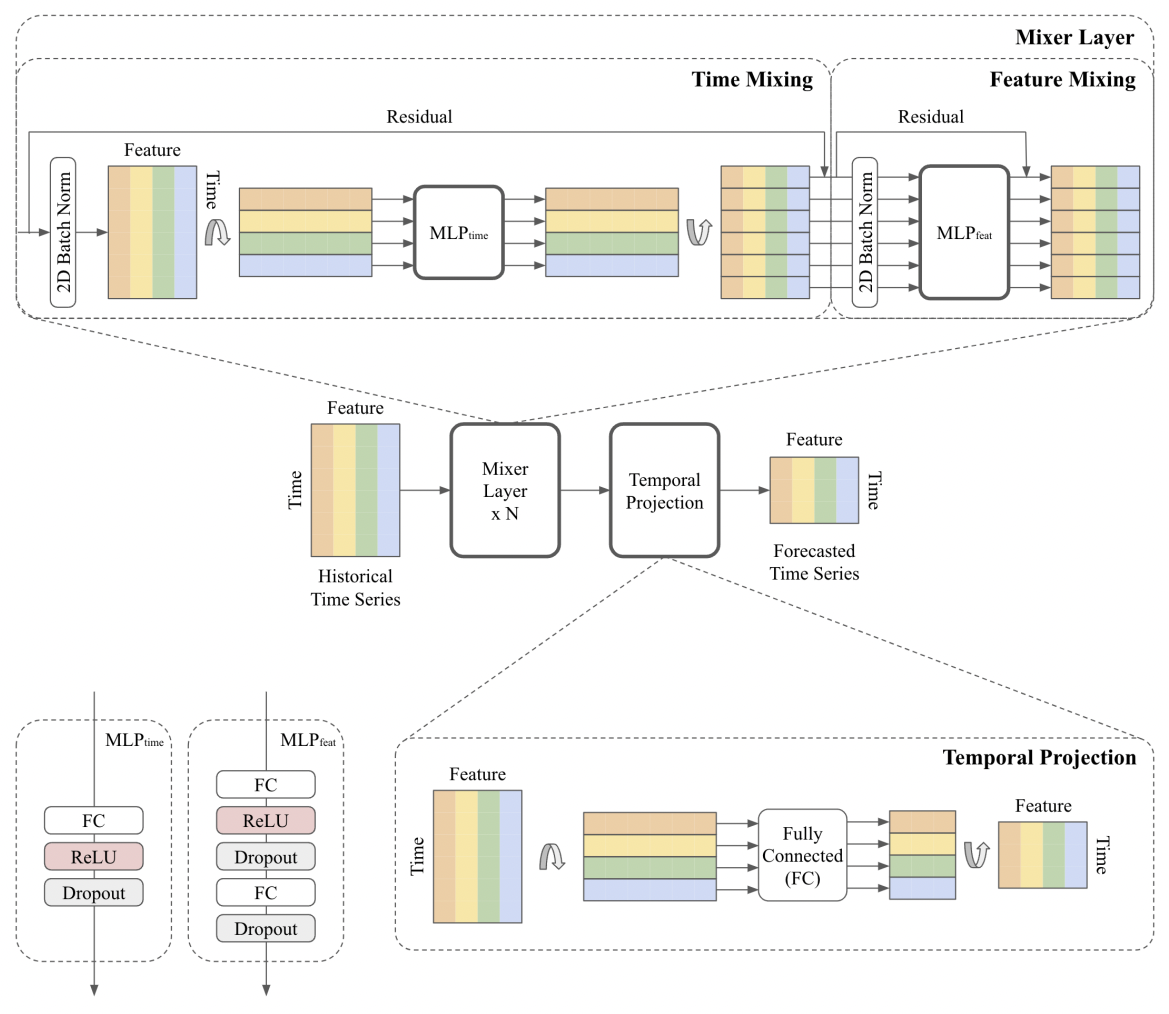

Let's define the `mixer_layer` and `temporal_projection` functions.

In [45]:
def mixer_layer(x, dropout=0.2, hidden_layer=32):
    # --- TIME MIXING ---
    # BATCH NORM
    x_norm = layers.BatchNormalization()(x)
    # RESHAPE (Batch, time, channels) -> (Batch, channels, time)
    x_time = layers.Permute((2, 1))(x_norm)
    # MLP time
    x_time = layers.Dense(x.shape[1], activation='relu')(x_time)
    x_time = layers.Dropout(dropout)(x_time)
    # RESHAPE (Batch, channels, time) -> (Batch, time, channels)
    x_out = layers.Permute((2, 1))(x_time)
    # CONNETION
    x = layers.Add()([x, x_out])

    # --- FEATURE MIXING ---
    # BATCH NORM
    x_norm = layers.BatchNormalization()(x)
    # MLP feature
    x_feat = layers.Dense(hidden_layer, activation='relu')(x_norm)
    x_feat = layers.Dropout(dropout)(x_feat)
    x_feat = layers.Dense(x.shape[-1])(x_feat)
    x_feat = layers.Dropout(dropout)(x_feat)
    # CONNETION
    x = layers.Add()([x, x_feat])

    return x

In [46]:
def temporal_projection(x, pred_len):
    # RESHAPE (Batch, time, channels) -> (Batch, channels, time)
    x = layers.Permute((2, 1))(x)
    # FULL. CONN.
    x = layers.Dense(pred_len)(x)
    # RESHAPE (Batch, channels, time) -> (Batch, time, channels)
    x = layers.Permute((2, 1))(x)

    return x

Define the model function `build_tsmixer_model`

In [47]:
def build_tsmixer_model(seq_len, pred_len, num_channels, n_block=4, hidden_layer=64, dropout=0.2):

    inputs = keras.Input(shape=(seq_len, num_channels))
    x = inputs

    # Mixer Block Stack
    for _ in range(n_block):
        x = mixer_layer(x, dropout=dropout, hidden_layer=hidden_layer)

    # Time Projection
    outputs = temporal_projection(x, pred_len)

    return keras.Model(inputs, outputs, name="TSMixer")

Once again, a *MSE* is chosen as the loss function and Adam as the optimizer with a learning rate of $0.001$

In [48]:
tf.keras.backend.clear_session()

model_tsmixer = build_tsmixer_model(seq_len, pred_len, len(df_hourly.columns), n_block=2, hidden_layer=64, dropout=0.2)
model_tsmixer.summary()

model_tsmixer.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'] )

Model: "TSMixer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120, 14)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 120, 14)   │         56 │ input_layer[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 14, 120)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 14, 120)   │     14,520 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 14, 120)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 120, 14)   │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 120, 14)   │          0 │ input_layer[0][0… │
│                     │                   │            │ permute_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 14)   │         56 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 120, 64)   │        960 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 120, 64)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 120, 14)   │        910 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 120, 14)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 120, 14)   │          0 │ add[0][0],        │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 14)   │         56 │ add_1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_2 (Permute) │ (None, 14, 120)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 14, 120)   │     14,520 │ permute_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 14, 120)   │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_3 (Permute) │ (None, 120, 14)   │          0 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 120, 14)   │          0 │ add_1[0][0],      │
│                     │                   │            │ permute_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 14)   │         56 │ add_2[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 120, 64)   │        960 │ batch_normalizat

 Total params: 35,908 (140.27 KB)

 Trainable params: 35,796 (139.83 KB)

 Non-trainable params: 112 (448.00 B)

In [49]:
history_tsmixer = model_tsmixer.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=create_callbacks('model_tsmixer')
)

Epoch 1/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.5316 - mae: 0.4739 - val_loss: 0.1981 - val_mae: 0.2727 - learning_rate: 0.0010
Epoch 2/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.2000 - mae: 0.2788 - val_loss: 0.1910 - val_mae: 0.2683 - learning_rate: 0.0010
Epoch 3/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.1906 - mae: 0.2701 - val_loss: 0.1883 - val_mae: 0.2683 - learning_rate: 0.0010
Epoch 4/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.1852 - mae: 0.2648 - val_loss: 0.1827 - val_mae: 0.2588 - learning_rate: 0.0010
Epoch 5/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.1817 - mae: 0.2614 - val_loss: 0.1819 - val_mae: 0.2590 - learning_rate: 0.0010
Epoch 6/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.1793 - mae: 0.2587 - val_loss: 0.1812 - val_mae: 0.2579 - learning_rate: 0.0010
Epoch 7/100
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.1774 - mae: 0.2563 - val_loss: 0.1789 - val_mae: 0.2

TSMixer training ended at epoch 65 (with weights reset at epoch 55), returning the **best overall** results among the tested models. Specifically, there was an improvement in the loss function of **-2.3%** compared to the BiLSTM model and **-16.8%** compared to the DLinear model. Furthermore, the training and validation curves remained close and consistent until the end.

## 6 Quantitative Evaluation

Once the training phase is complete, we need to objectively evaluate the models predictive ability. Since the model was trained on standardized data, the error metrics calculated during training cannot be directly interpreted in physical terms. To obtain a performance evaluation, we define a function (evaluate_temperature) that calculates the MAE and RMSE metrics in degrees Celsius (°C).

In [50]:
def evaluate_temperature(model, dataset, scaler):
    feature_idx = 5        # temperature index
    scaler_mean = scaler.mean_[1]
    scaler_std = scaler.scale_[1]

    total_abs_err = 0.
    total_sq_err = 0.
    count = 0

    for x, y in dataset:
        pred = model.predict(x, verbose=0)

        y_true_feat = y[:, :, feature_idx]
        y_pred_feat = pred[:, :, feature_idx]

        y_true_real = (y_true_feat * scaler_std) + scaler_mean
        y_pred_real = (y_pred_feat * scaler_std) + scaler_mean

        total_abs_err += np.sum(np.abs(y_true_real - y_pred_real))
        total_sq_err += np.sum((y_true_real - y_pred_real)**2)

        count += (y.shape[0] * y.shape[1]) # Batch * TimeSteps

    mae = total_abs_err / count
    mse = total_sq_err / count
    rmse = np.sqrt(mse)

    return mae, rmse

Before evaluating our deep learning models, we need to establish a minimum acceptable performance level. For time series, the most common baseline is Naive Persistence. In practice, if it's 20°C at 12:00 PM, the Naive model will predict that it will also be 20°C at 1:00 PM, 2:00 PM, etc. If our complex models can't beat this simple method (and achieve a lower MAE error), it means they haven't learned anything useful about the system dynamics.

We define a function (`evaluate_naive_persistence`) that calculates the Naive Persistence error directly in real degrees (°C), processing the dataset one batch at a time to save memory.

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_naive_persistence(dataset, scaler):
    feature_idx = 5  # temperature index
    feat_mean = scaler.mean_[1]
    feat_std = scaler.scale_[1]

    all_preds = []
    all_targets = []

    for x, y in dataset:
        last_val = x[:, -1, feature_idx]
        naive_pred = np.repeat(np.expand_dims(last_val, axis=1), pred_len, axis=1)

        true_feat = y[:, :, feature_idx]

        all_preds.append(naive_pred)
        all_targets.append(true_feat)

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Denormalization
    pred_real = (all_preds * feat_std) + feat_mean
    true_real = (all_targets * feat_std) + feat_mean

    mae = mean_absolute_error(true_real.flatten(), pred_real.flatten())
    rmse = np.sqrt(mean_squared_error(true_real.flatten(), pred_real.flatten()))

    return mae, rmse

After defining the metrics and the baseline, we now proceed to systematically calculate the errors on the Test Set.

In [52]:
naive_mae, naive_rmse = evaluate_naive_persistence(test_ds, scaler)

results = []
results.append({'Model': 'Naive (Baseline)', 'MAE (°C)': naive_mae, 'RMSE (°C)': naive_rmse})

models_dict = { 'DLinear': model_dl, 'BiLSTM': model_bilstm, 'TSMixer': model_tsmixer}

for name, model in models_dict.items():
    mae, rmse = evaluate_temperature(model, test_ds, scaler)
    results.append({'Model': name, 'MAE (°C)': mae, 'RMSE (°C)': rmse})

df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='MAE (°C)')

display(df_results)

Model  MAE (°C)  RMSE (°C)
3           TSMixer  1.655846   2.171836
2            BiLSTM  1.700071   2.201447
1           DLinear  1.904858   2.529501
0  Naive (Baseline)  3.420953   4.581651

By analyzing the final ranking with the correctly denormalized values, we can draw meaningful conclusions about the nature of the problem and the effectiveness of the different architectures:

1. **A significant gap compared to the Baseline**: The most striking finding is the gulf separating the Naive Baseline ($3.42^\circ C$) from the machine learning models (all between $1.65^\circ C$ and $1.90^\circ C$).
    * The **best model (TSMixer)** halved the error (-51%) compared to simple persistence.
    * Therefore, the temperature is not a "random walk," but follows deterministic dynamics that neural networks have learned to model.
2. **Linearity Limits and "Deep" Strength**: The **DLinear** stops at an MAE of $1.90^\circ C$. Although this is significantly better than the baseline, it still trails the "Deep" models ($1.65 - 1.70^\circ C$) by about 0.25°C.
    * This gap demonstrates that the relationship between weather variables is not purely linear. There is a complex component (nonlinear interactions between humidity, thermal inertia, and pressure) that **DLinear** cannot fully capture mathematically.
    * However, it is important to highlight the **DLinear** result: the introduction of a simple dense layer architecture, albeit lacking recurrence or depth, is sufficient to drastically reduce the Baseline error, demonstrating the model's ability to capture the global dynamics (trends and seasonality) of the time series.
3. **Head-to-Head (BiLSTM vs TSMixer)**: The battle for first place was extremely close:
* **BiLSTM**: $1.7^\circ C$
* **TSMixer**: $1.66^\circ C$

    **TSMixer** wins by a margin of about $0.04^\circ C$. The result is theoretically significant: TSMixer achieved this performance using only MLP (Dense) layers, without the computational complexity of recurrent cells (LSTM) and demonstrating superior generalization capability.

4. **Absolute Precision**: Obtaining an average error of only 1.66°C over a 24-hour forecast horizon, using exclusively historical data (without the aid of numerical physical models such as GFS or ECMWF), is an excellent result that validates the quality of the Data-Driven approach.

## 7 Graphical Inference

After validating the models numerically, we move on to qualitative analysis. In this section, we visualize the predictions of our models by comparing them with each other and with real data.

We define a function (`plot_real_values_comparison`) that extracts random samples from the test set, denormalizes the data, and creates a continuous time plot.

In [53]:
def plot_real_values_comparison(dataset, models_list, model_names, scaler, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    # Retrieving parameters to denormalize
    feature_mean = scaler.mean_[1]
    feature_std = scaler.scale_[1]
    # Batch calculation
    num_sequences = len(df_test) - (seq_len + pred_len) + 1
    num_batches = math.ceil(num_sequences / batch_size) if num_sequences > 0 else 0

    random_skip = np.random.randint(0, num_batches)
    try:
        sample = next(iter(dataset.skip(random_skip).take(1)))
    except:
        sample = next(iter(dataset.take(1)))

    inputs, targets = sample

    # DENORMALIZATION
    past_data = (inputs[0, :, 5].numpy() * feature_std) + feature_mean
    true_future = (targets[0, :, 5].numpy() * feature_std) + feature_mean

    past_steps = np.arange(-len(past_data), 0)
    future_steps = np.arange(0, len(true_future))

    # PLOTTING
    ax.plot(past_steps, past_data, label='Historical', color='#1f77b4', linewidth=1.5)
    ax.plot(future_steps, true_future, label='Real Target', color='gray', alpha=0.7, linestyle='--', linewidth=2)

    colors = ['#ff7f0e', '#2ca02c', '#d62728']

    # LOOP MODELS
    for i, model in enumerate(models_list):
        pred_batch = model.predict(inputs, verbose=0)
        pred = (pred_batch[0, :, 5] * feature_std) + feature_mean

        ax.plot(future_steps, pred, label=f'{model_names[i]}', color=colors[i % len(colors)], linewidth=2)
        ax.scatter(future_steps[-1], pred[-1], color=colors[i % len(colors)], edgecolors='black', s=30, zorder=5)

    ax.scatter(future_steps[-1], true_future[-1], color='gray', edgecolors='black', s=50, zorder=6)

    ax.axvline(x=0, color='black', linestyle='-', alpha=0.2)
    ax.set_title(f"Sample Random #{random_skip}", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)

    ax.set_xlabel('Time Step (1 hour intervals)', fontsize=12)
    ax.set_ylabel('Temperature (°C)', fontsize=12)

    ax.legend(fontsize=8, loc='upper left')

    if ax is None:
        plt.show()

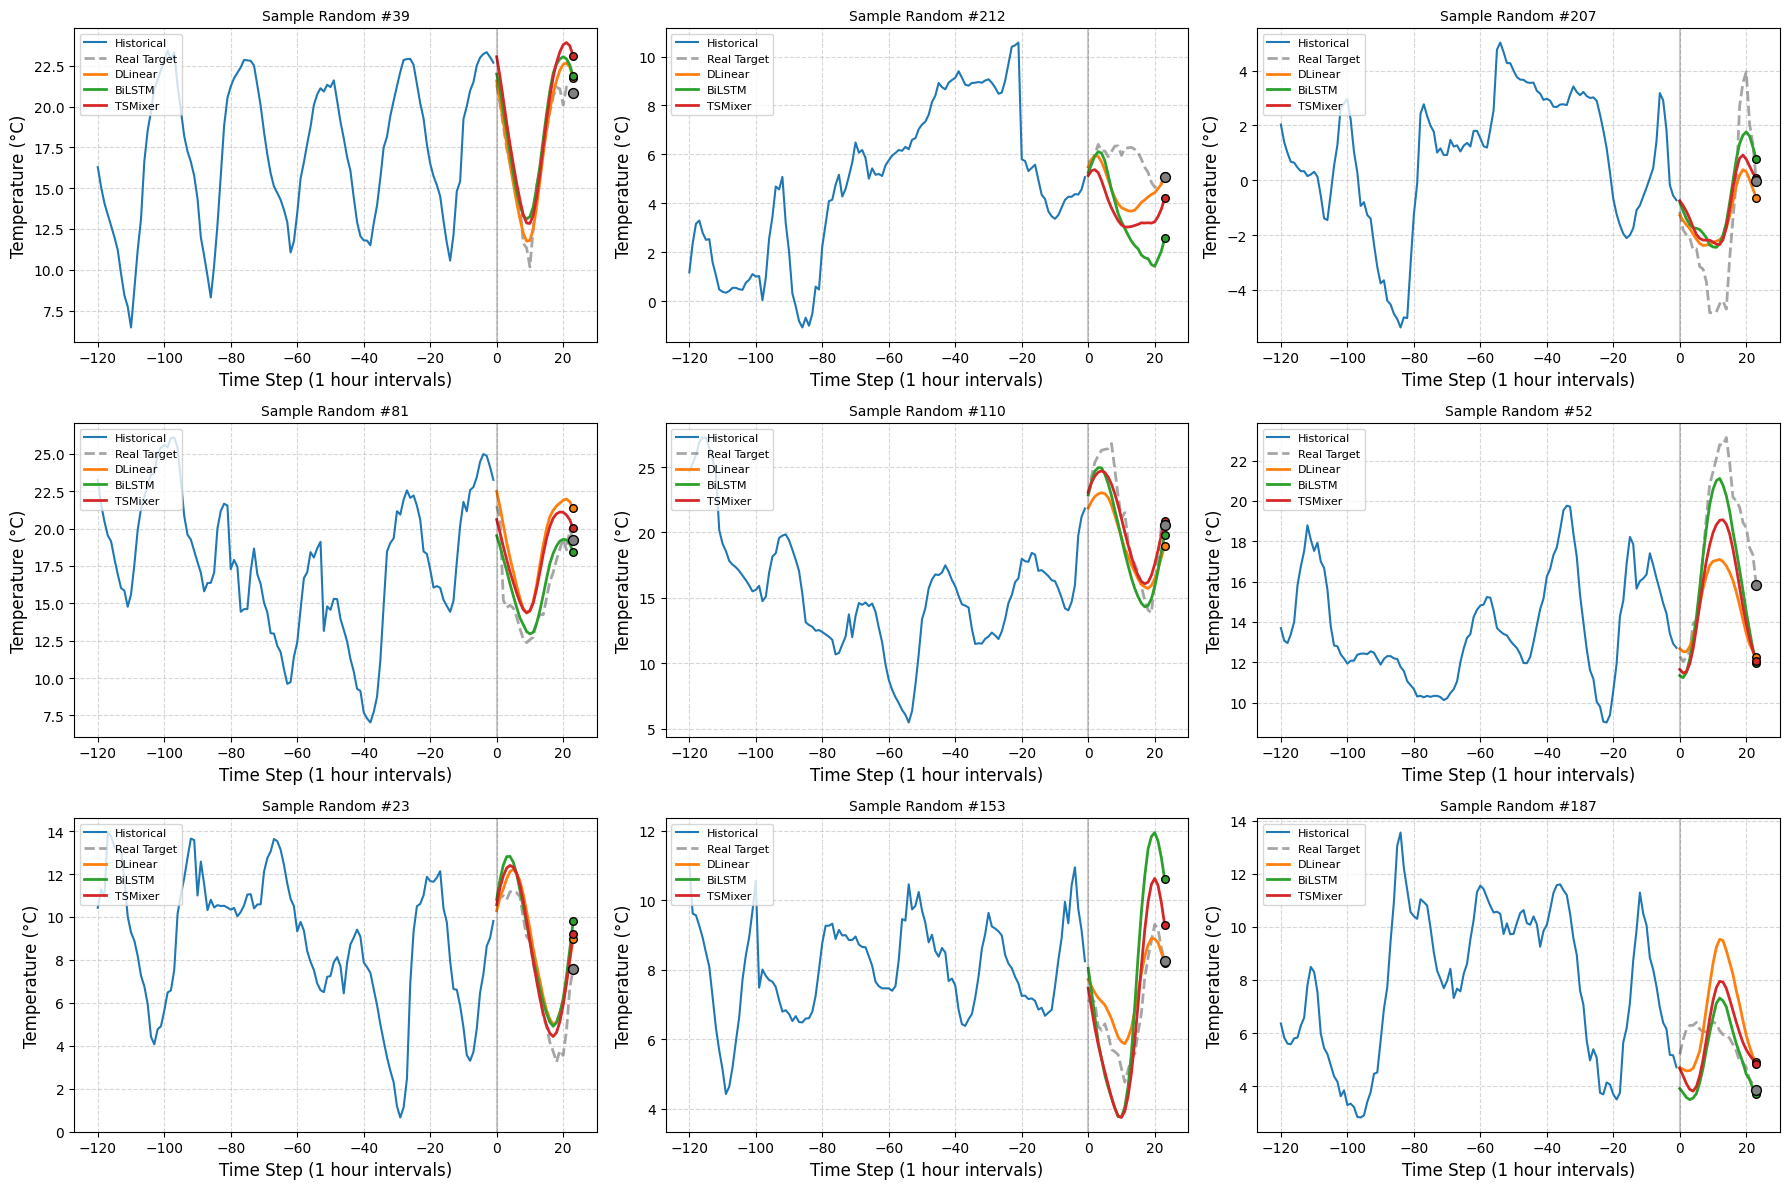

In [65]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes_flat = axes.flatten()

for i, ax in enumerate(axes_flat):
    plot_real_values_comparison(
        dataset=test_ds,
        models_list=[model_dl, model_bilstm, model_tsmixer],
        model_names=['DLinear', 'BiLSTM', 'TSMixer'],
        scaler=scaler,
        ax=ax
    )

plt.tight_layout()
plt.show()

## 8 Conclusions

In this study, we addressed the problem of **Multi-Step Time Series Forecasting** (24-hour forecast) applied to climate data from the **Jena station**. The goal was to outperform a persistence baseline (Naive) by comparing three different deep learning architectures: Linear (DLinear), Recurrent (BiLSTM), and MLP-Mixer (TSMixer).

Main Results:
1. **Machine Learning Domain**: All tested models significantly reduced the error compared to the Naive Baseline (MAE $\sim 3.42°C$). The best model (TSMixer) reduced the error by over 50%, demonstrating that temperature dynamics are highly deterministic and modelable.

2. **The Winner**: The TSMixer model confirmed its State-of-the-Art status (SOTA), achieving a mean absolute error (MAE) of approximately **1.66°C**. Its All-MLP architecture, which separates temporal mixing from feature mixing, proved superior to both the rigidity of linear models and the instability of recurrent networks, offering the best generalization on the Test Set.

3. **The Value of Simplicity (DLinear)**: DLinear surprised with its efficiency. Despite being an extremely simple model (based on linear decomposition and projections), it achieved remarkable results ($MAE \sim 1.90°C$). This suggests that a large portion of the weather signal is composed of linear trends and seasonality, although a gap remains compared to the non-linear capabilities of TSMixer.

Future Developments:
1. **Exogenous Data**: Integrate numerical forecasts (GFS/ECMWF physical models) as additional input to aid the network in dealing with sudden changes in weather fronts.

2. **Uncertainty Analysis**: Implement Probabilistic Forecasting (e.g., Quantile Regression) to predict not only the temperature, but also the confidence interval (e.g., "It will be between 19°C and 21°C with 90% probability").

In conclusion, the project demonstrates that modern MLP architectures (TSMixer) currently represent the best compromise between accuracy, stability, and training speed for climate time series forecasting.